In [1]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
import random

import sys
sys.path.append('..')
import merge_alg
sys.path.append('../experimental')
from size_model import SizeModel
sys.path.append('../common')
import util
import common_probs
import sampling_misc

# Binary Strings

I am going to turn my attention to trying to solve the problem in the simplest case possible: we have a binary alphabet and see each letter with equal probability. From these assumptions we have the fact that we see generalized letters $\{0\}, \{1\}$, and $\{0, 1\}$ each with probability $1/3$.

An interesting way of thinking about this problem for this scenario is that under the case in which we draw strings randomly from the set of generalized strings, there is a $2/3$ chance that any given index is deterministic (i.e. the generalized string was $\{0\}, \{1\}$. Otherwise, there is a 50-50 probability of that index being either a $0$ or a $1$. In picture form...

$$
XXXXOXXOXXXXOOXOXXXOXX
$$

where $X$ represents deterministic point and $O$ represents a random entry. Because the only place the tree can potentially split is at an $O$, I attempted analyzing sequences of the form $OXXXX...$ (i.e. random followed by deterministic). A full string is then just several of these stacked together. There are then several questions about this subsequence that needs answering:

1. How long is the subsequence?
2. When does one of these new subsequences mean a split in the tree?
3. If there was a split when we hit a new one of these substrings, how long does it last before getting merged back together?

If we can answer these questions and figure out how many sequences are "active" (their split has not merged yet), then we should be able to estimate how many states there are in total. That is, total should be

$$
\textrm{Total states} = \sum_d^n 2^{\textrm{Number of subsequences active} - 1}
$$

## Questions 1: How long is the subsequence?

It is apparent that the length of this will be distributed as a geometric random variable since the probability of us stopping on any given new letter is $1/3$. Thus, in particular the distribution is $Geom(1/3)$ and the average length is 4. 

## Question 2: When is there a split?

Consider a single branch in the tree and the next letter is random, so there is a chance that we will branch after this point. Note that up to this point we have the same failure transition necessarily so the only way that we can split is if the failures differ. This will happen if we are able to expand the suffix matching with a prefix by a 1 or a 0 but not both. Thus the probability that we will split should be equal to the probability of seeing a $\{0\}$ or a $\{1\}$ in the generalized string = $2/3$.

## Question 3: When do we merge?

Because we are in the binary case and we assume things that follow are deterministic, we merge back together when we hit a mismatch with our prefix-suffix pair. This happens with probability $1 - c_2$. This is a general idea though, there are possibilities of merging with other branches that is not being considered here.


Putting all of this together...

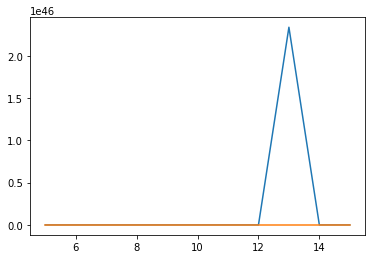

[27.924, 206.368, 264.268, 73833421.97, 3.689528982095583e+17, 1.0384593717070838e+31, 71784795630.94, 1.9343016032525342e+22, 2.338402619730509e+46, 2.475927494312998e+24, 1.0910303389759117e+37]
[9.092, 11.432, 15.559, 17.958, 22.516, 26.131, 31.206, 32.896, 38.669, 45.088, 46.716]


In [2]:
c_2 = common_probs.get_c2(2)

# Upper bound for the binary string model.
def simulate_num_states(depth):
    # Initialize after depth 1 because deterministic up to that.
    total_states, branches = 2, 1
    for _ in xrange(depth - 1):
        # Possibly spawn new branches.
        if random.random() <= 1 / 3:
            to_add = 0
            for _ in xrange(branches):
                if random.random() <= 2 / 3:
                    to_add += 1
            branches += to_add
        # Otherwise possibly merge branches.
        else:
            to_subtract = 0
            for _ in xrange(branches - 1):
                if random.random() <= (1 - c_2):
                    to_subtract += 1
            branches -= to_subtract
        # Count number of states in this depth.
        total_states += 2 ** (branches - 1)
    return total_states

depths = range(5, 16)
sims = 1000
avg_model = [sum([simulate_num_states(d) for _ in xrange(sims)]) / sims for d in depths]
avg_sims = [sampling_misc.sample_total_states(sims, [0.5, 0.5], d)[0] for d in depths]
plt.plot(depths, avg_model)
plt.plot(depths, avg_sims)
plt.show()
print avg_model
print avg_sims

As one can see, this does not work well at all. This is probably because there are a lot of factors not yet being considered in the model.